In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core_update')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core_update import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.1e-3,0.1e-3,0.1e-3),
            matrix_dims = (256,256,256),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=11.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=30, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=3)

pos = 0.7

test_phantom.add_tissue_sphere((pos,-pos,0), 8, blood)
test_phantom.add_tissue_sphere((pos,0,0), 16, blood)
test_phantom.add_tissue_sphere((pos,pos,0), 32, blood)

test_phantom.add_tissue_sphere((-pos,-pos,0), 16, fat)
test_phantom.add_tissue_sphere((-pos,0,0), 32, fat)
test_phantom.add_tissue_sphere((-pos,pos,0), 8, fat)

test_phantom.add_tissue_sphere((0,-pos,0), 32, myocardium)
test_phantom.add_tissue_sphere((0,0,0), 8, myocardium)
test_phantom.add_tissue_sphere((0,pos,0), 16, myocardium)

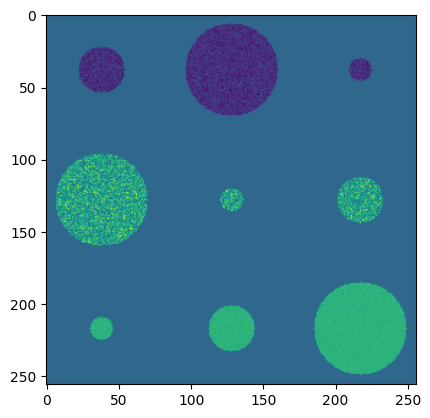

In [3]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [4]:
simprops = simulation.SimProperties(
                grid_size   = (20e-3,2e-3,2e-3),
                voxel_size  = (0.02e-3,0.02e-3,0.02e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [5]:
simprops.matrix_size

array([1024,  128,  128])

In [6]:
bounds = simprops.bounds
# transform = geometry.Transform((np.pi/3,0,0),(0,0,0))
transform = geometry.Transform((np.pi/4,np.pi/4,-np.pi/6),(0,0,0))
# transform = geometry.Transform((0,0,0),(0,0,0))
voxel_size = simprops.voxel_size
matrix_size = np.array(simprops.matrix_size) - np.array(simprops.PML_size)

In [7]:
out = test_phantom.crop_rotate_crop(bounds, transform, voxel_size, matrix_size)

pad_x,y,z (0, 46, 0)
first_crop_bounds_indices [[114 238]
 [  0 183]
 [112 159]]
cropped_matrix (124, 183, 47)
rotated_matrix (316, 316, 316)
input shape  (316, 316, 316)
target shape [198.4  24.   24. ]
start [ 58 146 146]
end   [258 170 170]
input shape  (1000, 120, 120)
target shape [992 120 120]
start [4 0 0]
end   [996 120 120]


In [8]:
out.shape

(2, 992, 120, 120)

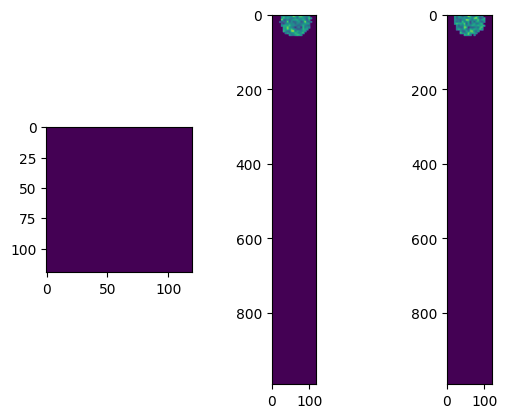

In [9]:
fig, ax = plt.subplots(1,3,)

ax[0].imshow(out[0,out.shape[1]//2,:,:])
ax[1].imshow(out[0,:,out.shape[2]//2,:])
ax[2].imshow(out[0,:,:,out.shape[3]//2])

In [10]:
transducers = [transducer.Focused(elements = 32, 
                       elevation = 1e-4 * 32, 
                       sensor_sampling_scheme = 'not_centroid', 
                       sweep = np.pi/6, 
                       ray_num = 32, 
                       imaging_ndims = 2,
                       focus_azimuth = 50e-3,
                       focus_elevation = 50e-3,
                       ) for i in range(1)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

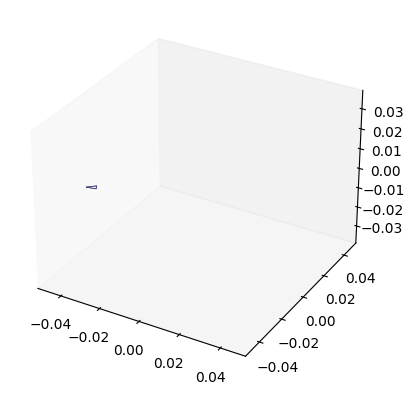

In [11]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
test_transducer_set.generate_extrinsics(shape="spherical", extrinsics_kwargs={'r_mean': 50e-3, 'view_std': 0, 'yaw_fraction': 0.3, 'pitch_fraction': 0, 'roll_fraction': 0})
test_transducer_set.plot_transducer_fovs(scale=0.05)

In [12]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='single_transducer')

In [13]:
simprops = simulation.SimProperties(
                grid_size   = (20e-3,2e-3,2e-3),
                voxel_size  = (0.02e-3,0.02e-3,0.02e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [14]:
simprops.matrix_size

array([1024,  128,  128])

In [15]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/test_updated_experiment_1',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 2,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 )

test_experiment.save()

In [16]:
# test_experiment = Experiment.load('../test_experiment_03')
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


In [17]:
test_experiment.run()

running with 3 workers

pad_x,y,z (545, 13, 0)
pad_x,y,z (553, 0, 0)
first_crop_bounds_indices [[1173 1362]
 [ 114  202]
 [ 116  140]]
cropped_matrix (189, 88, 24)
first_crop_bounds_indices [[1153 1346]
 [ 218  282]
 [ 116  140]]
cropped_matrix (193, 64, 24)
rotated_matrix (327, 327, 327)
input shape  (327, 327, 327)
target shape [192.   22.4  22.4]
start [ 68 152 152]
end   [260 176 176]
rotated_matrix (334, 334, 334)
input shape  (334, 334, 334)
target shape [192.   22.4  22.4]
start [ 71 155 155]
end   [263 179 179]
input shape  (960, 120, 120)
target shape [960 112 112]
start [0 4 4]
end   [960 116 116]
input shape  (960, 120, 120)
target shape [960 112 112]
start [0 4 4]
end   [960 116 116]
(2, 960, 112, 112)
preparation for sim    8 completed in            3.67 seconds
(2, 960, 112, 112)
preparation for sim    0 completed in            3.78 seconds
pad_x,y,z (547, 5, 0)pad_x,y,z (553, 0, 0)
first_crop_bounds_indices [[1173 1362]
 [ 103  194]
 [ 116  140]]
cropped_matrix (189, 91,

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                           1024 x 128 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   6001 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                           1024 x 128 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   6001 │
├───────────────────────────────────────────────────────────────┤
│         